In [1]:
import pandas as pd
import os
import csv
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import json
from matplotlib.colors import LinearSegmentedColormap
import warnings
warnings.filterwarnings('ignore')

In [2]:
csvpath = os.path.join("csv-data", "anxiety-depression-data.csv")

# Read the CSV file into a pandas DataFrame
df = pd.read_csv(csvpath)

# Filter rows where the "state" column is not equal to "United States"
by_state_df = df[(df['State'] != 'United States') & 
                (df['Group'] == 'By State') & 
                (df['Indicator'] == 'Symptoms of Anxiety Disorder or Depressive Disorder')]
by_state_df['date_column'] = pd.to_datetime(by_state_df['Time Period Start Date'], format='%m/%d/%Y')
by_state_df['Year'] = by_state_df['date_column'].dt.year

state_mean_df = by_state_df.groupby('State')['Value'].mean()
had_states_val = state_mean_df.nlargest(3)
lad_states_val = state_mean_df.nsmallest(3)

#---#
lad_states = lad_states_val.index
had_states = had_states_val.index

Index(['Louisiana', 'Mississippi', 'Oklahoma'], dtype='object', name='State')

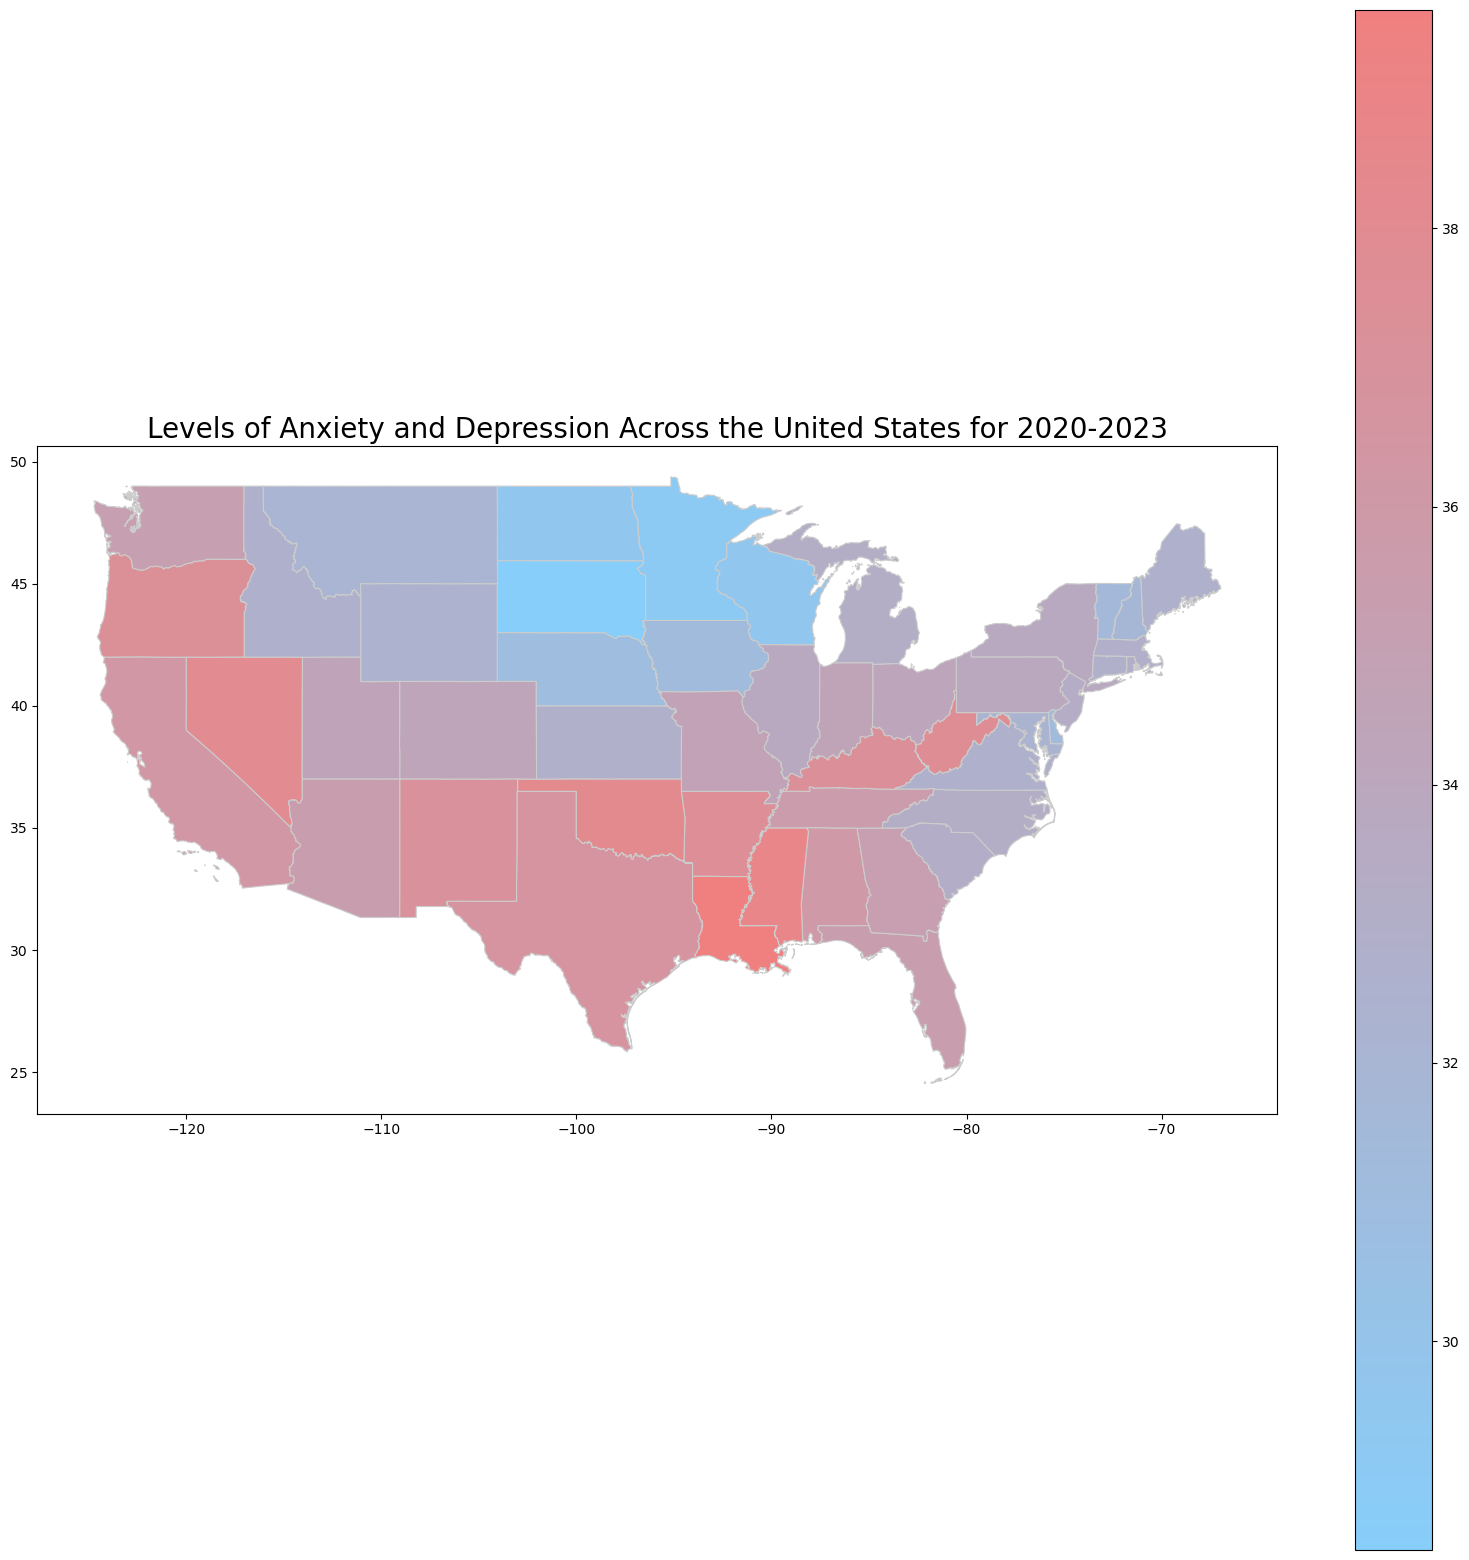

In [3]:
# Pull a json file with US states locations
json_path = os.path.join('csv-data', 'gz_2010_us_040_00_500k.json')
us_states = gpd.read_file(json_path)

# Rename the column 'NAME' to 'State' in the GeoDataFrame
us_states['State'] = us_states['NAME']
us_states = us_states.drop(columns=['NAME']).loc[(us_states['State'] != 'Alaska') 
                                                & (us_states['State'] != 'Hawaii')]
merged_df = us_states.merge(state_mean_df, on='State')

# Plot the map
fig, ax = plt.subplots(1, 1, figsize=(20, 20))

# Create a custom colormap
color1 = 'lightskyblue'
color2 = 'lightcoral'
cmap = LinearSegmentedColormap.from_list('custom_cmap', [color1, color2])
merged_df.plot(column='Value', cmap=cmap, linewidth=0.8, ax=ax, edgecolor='0.8', legend='true')

# Add a title and show the plot
plt.title('Levels of Anxiety and Depression Across the United States for 2020-2023', fontsize=20)
plt.show()

In [4]:
census_csv = os.path.join('csv-data', '2022-census.csv')
census_df = pd.read_csv(census_csv)
drop_columns = ['SUMLEV', 'ESTIMATESBASE2020', 'REGION', 'STATE', 'DIVISION']
population_df = census_df[census_df['NAME'].isin(lad_states + had_states)].drop(columns=drop_columns)

south_dakota_row = census_df[census_df['NAME'] == 'South Dakota']
minnesota_row = census_df[census_df['NAME'] == 'Minnesota']
north_dakota_row = census_df[census_df['NAME'] == 'North Dakota']

louisiana_row = census_df[census_df['NAME'] == 'Louisiana']
mississippi_row = census_df[census_df['NAME'] == 'Mississippi']
oklahoma_row = census_df[census_df['NAME'] == 'Oklahoma']

south_dakota_average_population = south_dakota_row[['POPESTIMATE2020', 'POPESTIMATE2021', 'POPESTIMATE2022']].astype(int).mean(axis=1)
south_dakota_pop = round(south_dakota_average_population.values[0])

minnesota_average_population = minnesota_row[['POPESTIMATE2020', 'POPESTIMATE2021', 'POPESTIMATE2022']].astype(int).mean(axis=1)
minnesota_pop = round(minnesota_average_population.values[0])

north_dakota_average_population = north_dakota_row[['POPESTIMATE2020', 'POPESTIMATE2021', 'POPESTIMATE2022']].astype(int).mean(axis=1)
north_dakota_pop = round(north_dakota_average_population.values[0])

louisiana_average_population = louisiana_row[['POPESTIMATE2020', 'POPESTIMATE2021', 'POPESTIMATE2022']].astype(int).mean(axis=1)
lousiana_pop = round(louisiana_average_population.values[0])

mississippi_average_population = mississippi_row[['POPESTIMATE2020', 'POPESTIMATE2021', 'POPESTIMATE2022']].astype(int).mean(axis=1)
mississippi_pop = round(mississippi_average_population.values[0])

oklahoma_average_population = oklahoma_row[['POPESTIMATE2020', 'POPESTIMATE2021', 'POPESTIMATE2022']].astype(int).mean(axis=1)
oklahoma_pop = round(oklahoma_average_population.values[0])

##----##
pop = {'State Name' : ['Louisiana', 'Mississippi', 'Oklahoma', 'South Dakota', 'Minnesota',  'North Dakota'],
              'Population' : [lousiana_pop, mississippi_pop, oklahoma_pop, south_dakota_pop, minnesota_pop, north_dakota_pop]}

In [5]:
#Import data sets
#Create Paths
unin_2019_path =  os.path.join('csv-data', '2019-unisured-pop-data.csv')
unin_2021_path =  os.path.join('csv-data', '2021-unisured-pop-data.csv')
unin_2022_path =  os.path.join('csv-data', '2022-unisured-pop-data.csv')
overdose_path =  os.path.join('csv-data', 'VSRR_Provisional_Drug_Overdose_Death_Counts.csv')
death_path =  os.path.join('csv-data', 'Weekly_Counts_of_Death_by_Jurisdiction_and_Select_Causes_of_Death.csv')

#Import .csv files into Panda Data Frames
unin_2019_full_df =  pd.read_csv(unin_2019_path)
unin_2021_full_df =  pd.read_csv(unin_2021_path)
unin_2022_full_df =  pd.read_csv(unin_2022_path)
overdose_full_df = pd.read_csv(overdose_path)
death_full_df = pd.read_csv(death_path)

In [6]:
%%markdown 
## Analysis of Causes of Death for States with Highest and Lowest Indices of Anxiety and Depression


## Analysis of Causes of Death for States with Highest and Lowest Indices of Anxiety and Depression


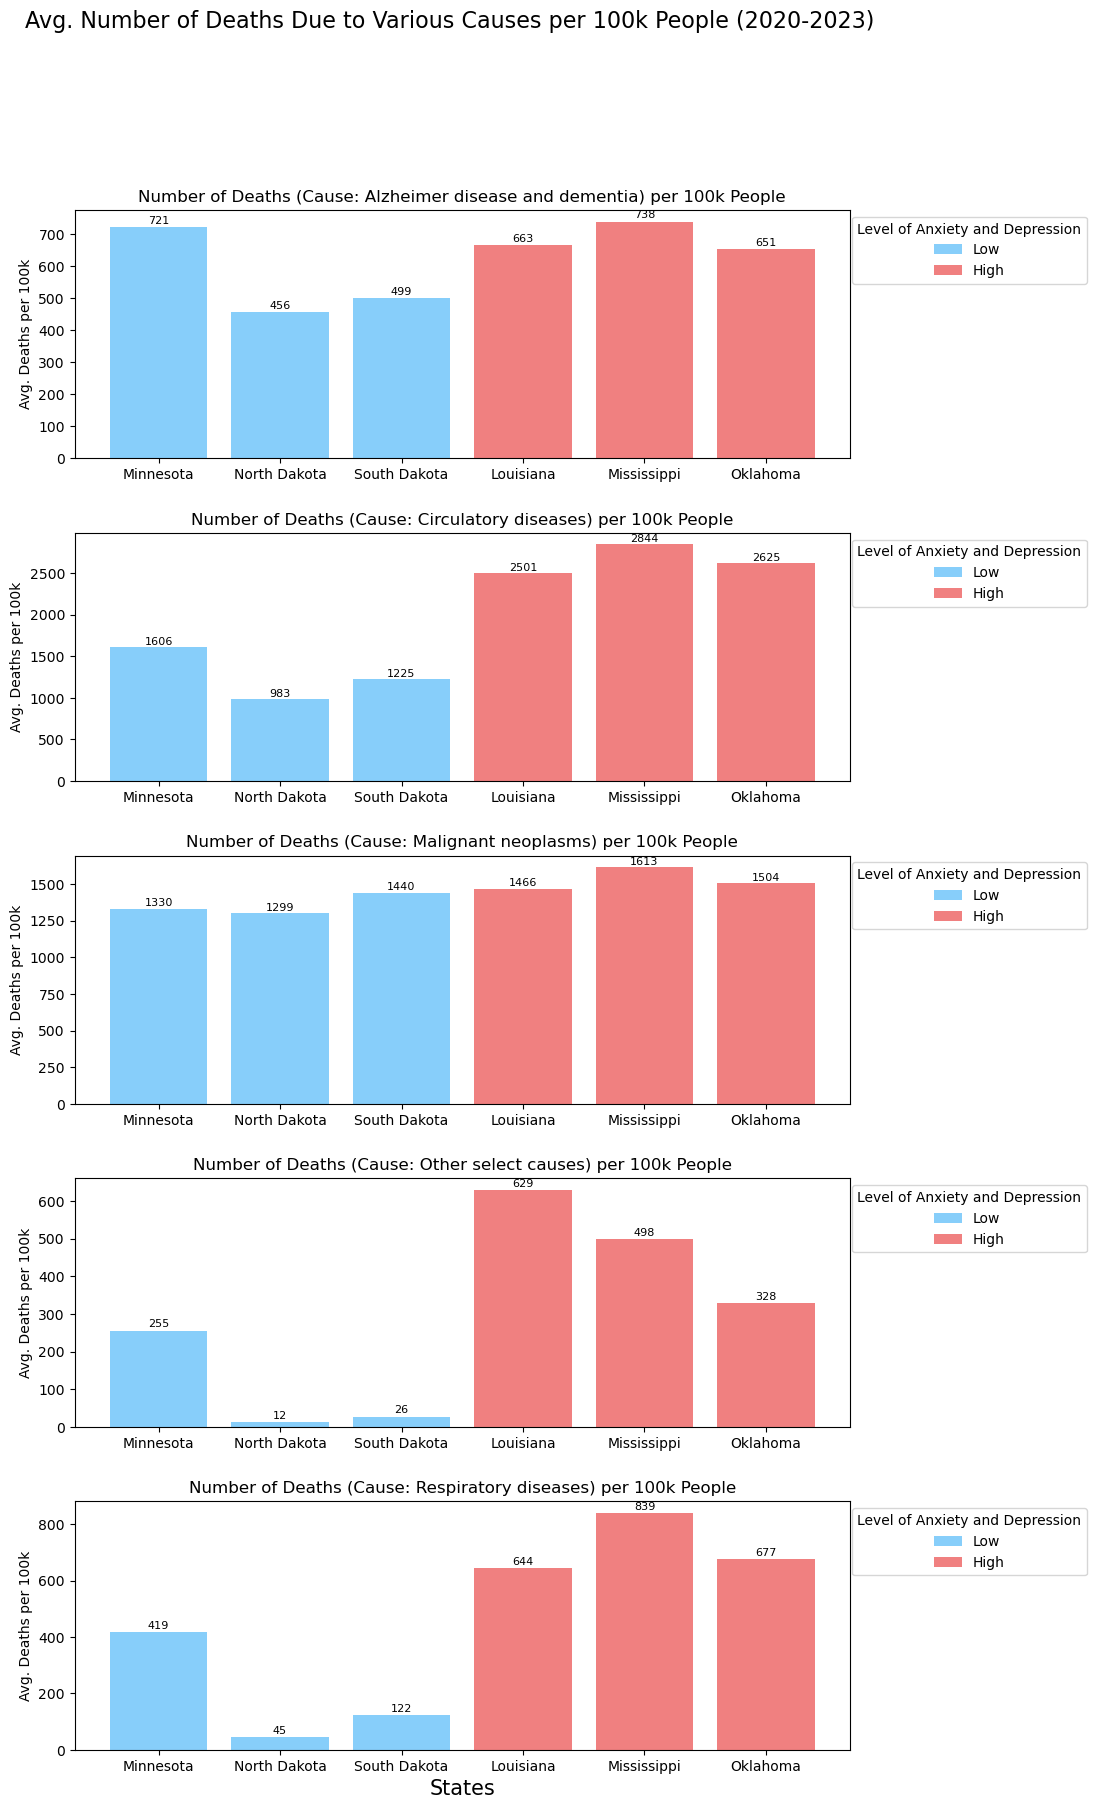

In [7]:
# Clean full data set and merge with State population DF
death_clean_df = death_full_df.loc[death_full_df['Time Period']!='2015-2019']
death_clean_df.rename(columns={'Jurisdiction': 'State Name'}, inplace=True)
death_clean_df = pd.merge(death_clean_df, pd.DataFrame(pop), on='State Name')

# Create individual data frames for each of the State groups and calculate rate of deaths per 100k
lad_death_clean_df = death_clean_df.loc[death_clean_df['State Name'].isin(lad_states)]
lad_death_clean_df = lad_death_clean_df.groupby(['Year', 'State Name', 'Population', 'Cause Group']) \
                    ['Number of Deaths'].sum().reset_index(level='Population')
lad_death_clean_df['Per Capita (100,000 of pop)'] = lad_death_clean_df['Number of Deaths']/(lad_death_clean_df['Population']/100000)
lad_death_clean_df_avg = lad_death_clean_df.groupby(['Cause Group', 'State Name'])['Per Capita (100,000 of pop)'].sum()

had_death_clean_df = death_clean_df.loc[death_clean_df['State Name'].isin(had_states)]
had_death_clean_df = had_death_clean_df.groupby(['Cause Group', 'Year', 'State Name', 'Population']) \
                    ['Number of Deaths'].sum().reset_index(level='Population')
had_death_clean_df['Per Capita (100,000 of pop)'] = had_death_clean_df['Number of Deaths']/(had_death_clean_df['Population']/100000)
had_death_clean_df_avg = had_death_clean_df.groupby(['Cause Group', 'State Name'])['Per Capita (100,000 of pop)'].sum()

# Determine all causes of death in DF
causes = death_clean_df['Cause Group'].unique()

# Plot 
fig, axs = plt.subplots(5, 1, figsize=(10, 20))
fig.suptitle('Avg. Number of Deaths Due to Various Causes per 100k People (2020-2023)', fontsize=16)
axs = axs.flatten()
i=0
for cause in causes:
    axs[i].bar(lad_death_clean_df_avg[cause].index, lad_death_clean_df_avg[cause], color='lightskyblue')
    axs[i].bar(had_death_clean_df_avg[cause].index, had_death_clean_df_avg[cause], color='lightcoral')
        # Add text labels for lad_death_clean_df_avg
    for x, y in zip(lad_death_clean_df_avg[cause].index, lad_death_clean_df_avg[cause]):
        axs[i].text(x, y + 5, f'{y:.0f}', ha='center', va='bottom', fontsize=8)
    for x, y in zip(had_death_clean_df_avg[cause].index, had_death_clean_df_avg[cause]):
        axs[i].text(x, y + 5, f'{y:.0f}', ha='center', va='bottom', fontsize=8)
        
    axs[i].set_title(f'Number of Deaths (Cause: {cause}) per 100k People')
    axs[i].set_ylabel('Avg. Deaths per 100k', fontsize=10)
    axs[i].legend(title='Level of Anxiety and Depression', labels=['Low', 'High'], loc='upper right', bbox_to_anchor=(1.315, 1))
    i = i+1
axs[i-1].set_xlabel('States', fontsize=15)
plt.subplots_adjust(hspace=0.3)
plt.show()



In [8]:
%%markdown 
## Analysis of Overdose Death (2020-2023) for States with Highest and Lowest Indices of Anxiety and Depression

## Analysis of Overdose Death (2020-2023) for States with Highest and Lowest Indices of Anxiety and Depression


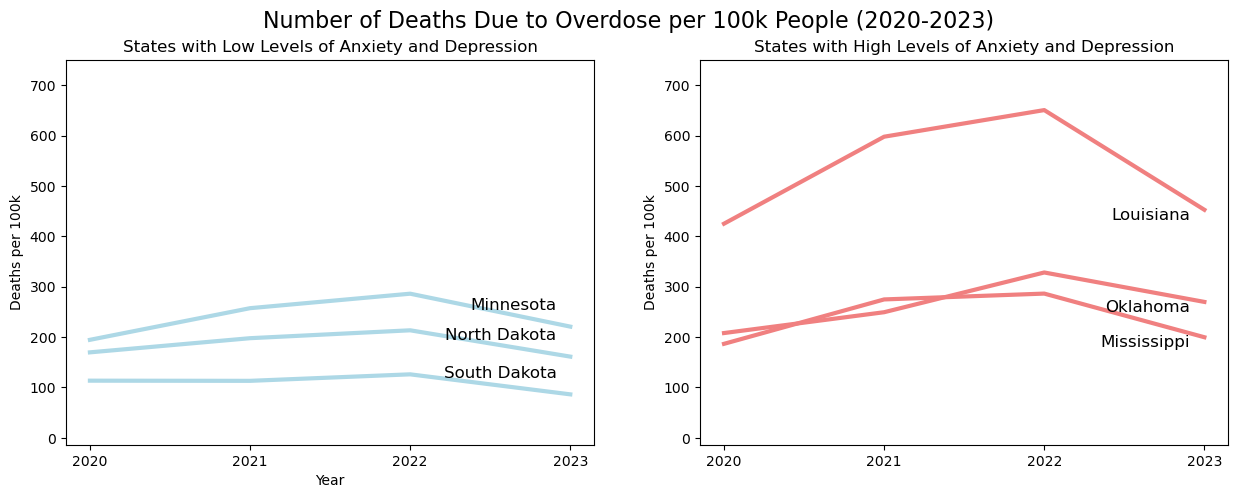

In [9]:

overdose_clean_df = overdose_full_df.loc[(overdose_full_df['Indicator'] == 'Number of Drug Overdose Deaths') 
                                        & (overdose_full_df['Year'] >= 2020)]
overdose_clean_df = pd.merge(overdose_clean_df, pd.DataFrame(pop), on='State Name')
lad_overdose_clean_df = overdose_clean_df.loc[overdose_clean_df['State Name'].isin(lad_states)]
lad_overdose_clean_df = lad_overdose_clean_df.groupby(['Year', 'State Name', 'Population']) \
                        ['Data Value'].sum().reset_index(level='Population')
lad_overdose_clean_df['Per Capita (100,000 of pop)'] = lad_overdose_clean_df['Data Value']/(lad_overdose_clean_df['Population']/100000)
lad_overdose_clean_df_tot = lad_overdose_clean_df.groupby(['State Name', 'Year'])['Per Capita (100,000 of pop)'].sum()

had_overdose_clean_df = overdose_clean_df.loc[overdose_clean_df['State Name'].isin(had_states)]
had_overdose_clean_df = had_overdose_clean_df.groupby(['Year', 'State Name', 'Population']) \
                        ['Data Value'].sum().reset_index(level='Population')
had_overdose_clean_df['Per Capita (100,000 of pop)'] = had_overdose_clean_df['Data Value']/(had_overdose_clean_df['Population']/100000)
had_overdose_clean_df_tot = had_overdose_clean_df.groupby(['State Name', 'Year'])['Per Capita (100,000 of pop)'].sum()

fig, axs = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Number of Deaths Due to Overdose per 100k People (2020-2023)', fontsize=16)
low_lim = min(lad_overdose_clean_df_tot.min(), had_overdose_clean_df_tot.min()) - 100
hig_lim = max(lad_overdose_clean_df_tot.max(), had_overdose_clean_df_tot.max()) + 100


for state in lad_states:
    axs[0].plot(lad_overdose_clean_df_tot[state].index.astype(str), lad_overdose_clean_df_tot[state], color='lightblue', linewidth=3)
    axs[0].annotate(state, (lad_overdose_clean_df_tot[state].index[-1].astype(str), lad_overdose_clean_df_tot[state].iloc[-1]),
                 textcoords="offset points", xytext=(-10, 12), ha='right', fontsize=12)
    axs[0].set_ylim(low_lim, hig_lim)
    axs[0].set_title('States with Low Levels of Anxiety and Depression')
    axs[0].set_ylabel('Deaths per 100k', fontsize=10)
    axs[0].set_xlabel('Year', fontsize=10)
for state in had_states:
    axs[1].plot(had_overdose_clean_df_tot[state].index.astype(str), had_overdose_clean_df_tot[state], color='lightcoral', linewidth=3)
    axs[1].annotate(state, (had_overdose_clean_df_tot[state].index[-1].astype(str), had_overdose_clean_df_tot[state].iloc[-1]),
                 textcoords="offset points", xytext=(-10, -7), ha='right', fontsize=12)
    axs[1].set_ylim(low_lim, hig_lim)
    axs[1].set_title('States with High Levels of Anxiety and Depression')
    axs[1].set_ylabel('Deaths per 100k', fontsize=10)
    axs[1].set_xlabel('Year', fontsize=10)




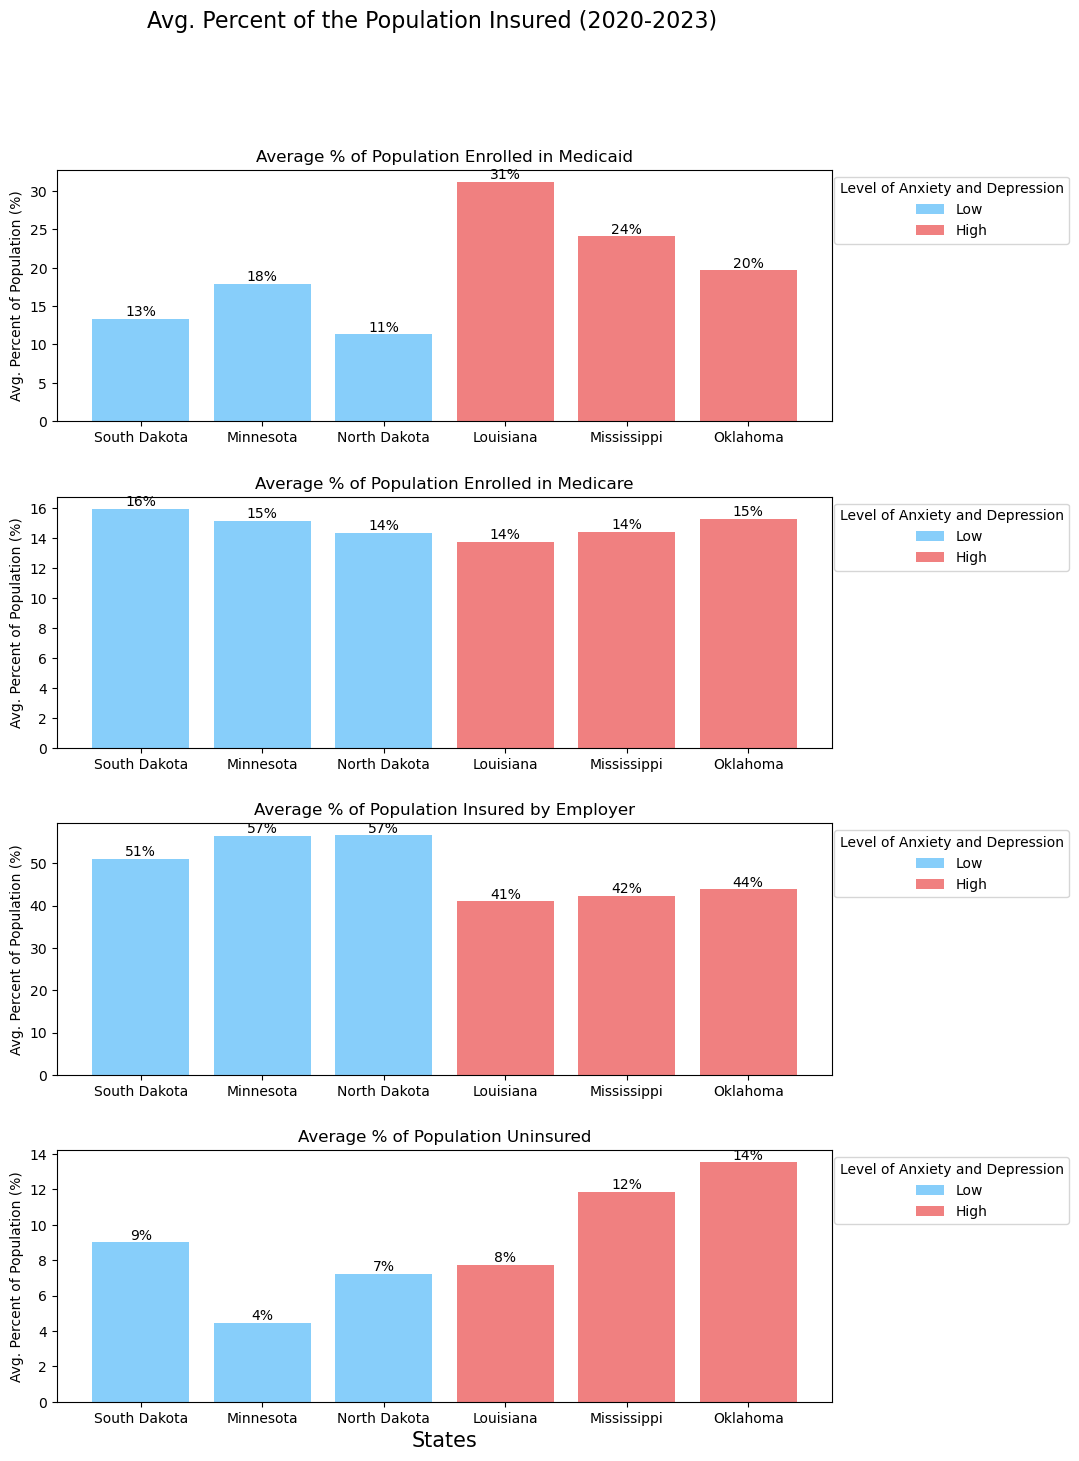

In [10]:
in_clean_df = pd.merge(unin_2019_full_df[['Location', 'Medicaid', 'Medicare', 'Uninsured', 'Employer']], 
                        unin_2021_full_df[['Location', 'Medicaid', 'Medicare', 'Uninsured', 'Employer']], on = 'Location')
in_clean_df = pd.merge(in_clean_df, unin_2022_full_df[['Location', 'Medicaid', 'Medicare', 
                                                       'Uninsured', 'Employer']], on = 'Location').dropna(how='any')
lad_states
lad_state_in_clean_df = []
for states in lad_states:
    lad_state_in_clean_df.append(in_clean_df.loc[in_clean_df['Location'] == states])
    
lad_state_in_clean_df = pd.concat(lad_state_in_clean_df, ignore_index=True)
lad_state_in_clean_df = lad_state_in_clean_df.rename(columns= {'Medicaid_x': 'Medicaid_2019',
                             'Medicaid_y': 'Medicaid_2021',
                             'Medicaid': 'Medicaid_2022',
                             'Medicare_x': 'Medicare_2019',
                             'Medicare_y': 'Medicare_2021',
                             'Medicare': 'Medicare_2022',
                             'Uninsured_x': 'Uninsured_2019',
                             'Uninsured_y': 'Uninsured_2021',
                             'Uninsured': 'Uninsured_2022',
                             'Employer_y': 'Employer_2021',
                             'Employer': 'Employer_2022',
                             'Employer_x': 'Employer_2019'})

avg_medicaid_lad = np.mean(lad_state_in_clean_df.set_index('Location')[['Medicaid_2019',
                                                                       'Medicaid_2021',
                                                                       'Medicaid_2022']], axis=1)
avg_medicare_lad = np.mean(lad_state_in_clean_df.set_index('Location')[['Medicare_2019',
                                                                       'Medicare_2021',
                                                                       'Medicare_2022']], axis=1)
avg_uninsured_lad = np.mean(lad_state_in_clean_df.set_index('Location')[['Uninsured_2019',
                                                                        'Uninsured_2021',
                                                                        'Uninsured_2022']], axis=1)
avg_employer_lad = np.mean(lad_state_in_clean_df.set_index('Location')[['Employer_2019',
                                                                        'Employer_2021',
                                                                        'Employer_2022']], axis=1)

had_state_in_clean_df = []
for states in had_states:
    had_state_in_clean_df.append(in_clean_df.loc[in_clean_df['Location'] == states])
    
had_state_in_clean_df = pd.concat(had_state_in_clean_df, ignore_index=True)
had_state_in_clean_df = had_state_in_clean_df.rename(columns= {'Medicaid_x': 'Medicaid_2019',
                             'Medicaid_y': 'Medicaid_2021',
                             'Medicaid': 'Medicaid_2022',
                             'Medicare_x': 'Medicare_2019',
                             'Medicare_y': 'Medicare_2021',
                             'Medicare': 'Medicare_2022',
                             'Uninsured_x': 'Uninsured_2019',
                             'Uninsured_y': 'Uninsured_2021',
                             'Uninsured': 'Uninsured_2022',
                             'Employer_y': 'Employer_2021',
                             'Employer': 'Employer_2022',
                             'Employer_x': 'Employer_2019'})

avg_medicaid_had = np.mean(had_state_in_clean_df.set_index('Location')[['Medicaid_2019',
                                                                       'Medicaid_2021',
                                                                       'Medicaid_2022']], axis=1)
avg_medicare_had = np.mean(had_state_in_clean_df.set_index('Location')[['Medicare_2019',
                                                                       'Medicare_2021',
                                                                       'Medicare_2022']], axis=1)
avg_uninsured_had = np.mean(had_state_in_clean_df.set_index('Location')[['Uninsured_2019',
                                                                       'Uninsured_2021',
                                                                       'Uninsured_2022']], axis=1)
avg_employer_had = np.mean(had_state_in_clean_df.set_index('Location')[['Employer_2019',
                                                                       'Employer_2021',
                                                                       'Employer_2022']], axis=1)

def plot_insurance(data_lad, data_had, title, i):
    axs[i].bar(data_lad.index, data_lad*100, color='lightskyblue', label='Group 1')
    axs[i].bar(data_had.index, data_had*100, color='lightcoral', label='Group 2')
    axs[i].set_title(title)
    axs[i].set_ylabel('Avg. Percent of Population (%)')
    axs[i].legend(title='Level of Anxiety and Depression', labels=['Low', 'High'], loc='upper right', bbox_to_anchor=(1.315, 1))
            # Add text labels for lad_death_clean_df_avg
    for x, y in zip(data_lad.index, data_lad*100):
        axs[i].text(x, y, f'{y:.0f}%', ha='center', va='bottom', fontsize=10)
    for x, y in zip(data_had.index, data_had*100):
        axs[i].text(x, y, f'{y:.0f}%', ha='center', va='bottom', fontsize=10)
    
fig, axs = plt.subplots(4, 1, figsize=(10, 16))
fig.suptitle('Avg. Percent of the Population Insured (2020-2023)', fontsize=16)
plot_insurance(avg_medicaid_lad, avg_medicaid_had, 'Average % of Population Enrolled in Medicaid', 0)
plot_insurance(avg_medicare_lad, avg_medicare_had, 'Average % of Population Enrolled in Medicare', 1)
plot_insurance(avg_employer_lad, avg_employer_had, 'Average % of Population Insured by Employer', 2)
plot_insurance(avg_uninsured_lad, avg_uninsured_had, 'Average % of Population Uninsured', 3)

axs[3].set_xlabel('States', fontsize=15)
plt.subplots_adjust(hspace=0.3)
plt.show()

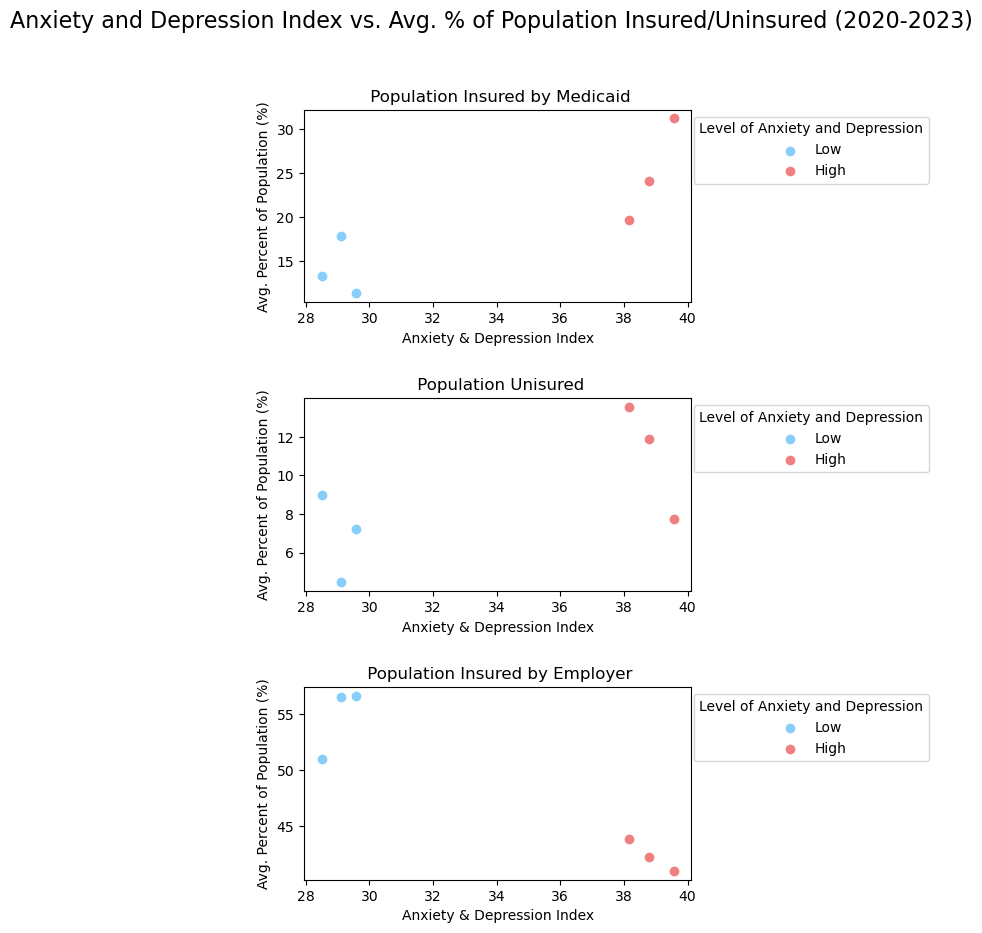

In [11]:


def scatter_plot(data_lad, data_had, ax, title):
    data_lad = pd.DataFrame(data_lad, columns=['Avg In']).rename_axis('State').reset_index()
    data_lad = pd.merge(data_lad, lad_states_val, on='State')
    data_lad['Plot Color Index'] = [0, 0, 0]
    data_had = pd.DataFrame(data_had, columns=['Avg In']).rename_axis('State').reset_index()
    data_had = pd.merge(data_had, had_states_val, on='State')
    data_had['Plot Color Index'] = [1, 1, 1]
    
    axs[ax].scatter(data_lad['Value'], data_lad['Avg In']*100, c='lightskyblue')
    axs[ax].scatter(data_had['Value'], data_had['Avg In']*100, c='lightcoral')
    axs[ax].set_title(title)
    axs[ax].set_ylabel('Avg. Percent of Population (%)')
    axs[ax].set_xlabel('Anxiety & Depression Index')
    axs[ax].legend(title='Level of Anxiety and Depression', labels=['Low', 'High'], loc='upper right', bbox_to_anchor=(1.63, 1))

fig, axs = plt.subplots(3, 1, figsize=(5,10))
fig.suptitle('Anxiety and Depression Index vs. Avg. % of Population Insured/Uninsured (2020-2023)', fontsize=16)
scatter_plot(avg_medicaid_lad, avg_medicaid_had, 0, ' Population Insured by Medicaid')
scatter_plot(avg_uninsured_lad, avg_uninsured_had, 1, ' Population Unisured')
scatter_plot(avg_employer_lad, avg_employer_had, 2, ' Population Insured by Employer')
plt.subplots_adjust(hspace=0.5)
plt.show()
